In [2]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as u

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging


In [3]:
#d = pickle.load(open("forecaster_params.pickle"))
#d["files"] = "tuned_mueller_pulses_selected"
#d["toa_mode"] = "pipeline"
d = pickle.load(open("fitter_params.pickle"))
F = threebody.Fitter(**d)


In [5]:
res = F.residuals()
print F.goodness_of_fit(F.best_parameters)

151134.353225


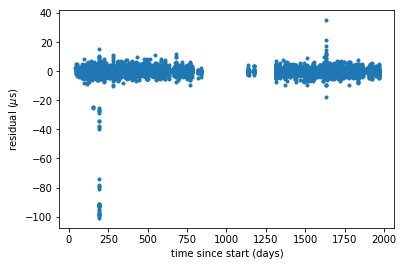

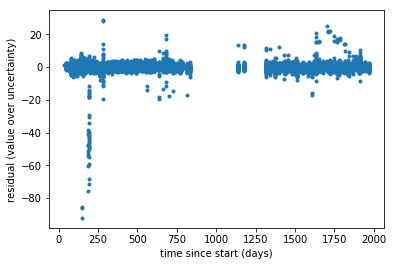

In [11]:
plt.plot(F.mjds, 1e6*res/F.reference_f0, ".")
plt.xlabel("time since start (days)")
plt.ylabel(r"residual ($\mu$s)")
plt.savefig("current-fitter-residuals.pdf", dpi=600, rasterize=True)
plt.figure()
plt.plot(F.mjds, res/F.phase_uncerts, ".")
plt.xlabel("time since start (days)")
plt.ylabel(r"residual (value over uncertainty)")
plt.savefig("current-fitter-z.pdf")


In [ ]:
bot = 0.1
top = 3
plt.loglog(1e6*F.phase_uncerts/F.reference_f0, 
           1e6*res/F.reference_f0, ",")
plt.loglog([bot,top],[bot,top])
plt.xlabel(r"Claimed uncert ($\mu$s)")
plt.ylabel(r"Actual residual ($\mu$s)")
plt.savefig("uncert-vs-resid.pdf")

In [ ]:
F.best_parameters

In [ ]:
threebody.hexplot(F.best_parameters, F.mjds, 
                  1e6*res/F.reference_f0,
                  gridsize=(10,30))
plt.colorbar(label="residual ($\mu$s)")

## Making TOAs-with-residuals

In [ ]:
toa_infos = threebody.read_t2_toas("tuned_mueller_pulses_selected.tim")
if len(toa_infos)!=len(res):
    raise ValueError
ixi = np.argsort(F.ix)
for (i,t) in enumerate(toa_infos):
    i_F = ixi[i]
    #print i, i_F, F.phase_uncerts[i_F]
    u_F = 1e6*F.phase_uncerts[i_F]/F.reference_f0
    u_t = t["uncert"]
    if np.abs(u_F - u_t)>1e-3:
        raise ValueError("Uncertainties do not agree: %g and %g"
                         % (u_F, u_t))
    t["flags"]["resid_phase"] = res[i_F]
    t["flags"]["resid_s"] = res[i_F]/F.reference_f0
    t["flags"]["day_bary"] = F.mjds[i_F]
    t["flags"]["uncert_phase"] = F.phase_uncerts[i_F]


In [ ]:
threebody.write_t2_toas("tuned_mueller_pulses_selected_residuals.tim",
                        toa_infos)


In [ ]:

zs = [np.abs(t["flags"]["resid_phase"]/t["flags"]["uncert_phase"])
      for t in toa_infos]
ix = np.argsort(zs)[::-1]
i = 0
files = {}
z = np.inf
while(z)>10:
    t = toa_infos[ix[i]]
    f = t["file"]
    o = f.split("/")[2]
    if o not in files:
        z = zs[ix[i]]
        files[o] = [z,
                    1e6*t["flags"]["resid_s"], 
                    t["uncert"], 
                    0]
    files[o][3] += 1        
    i += 1
    
os = []
zss = []
rs = []
us = []
ns = []
for k, v in sorted(files.items()):
    os.append(k)
    zss.append(v[0])
    rs.append(v[1])
    us.append(v[2])
    ns.append(v[3])
    
rows = [[k, v[0], v[1], v[2], v[3]] for (k,v) in sorted(files.items())]
rows.sort(key=lambda r: -r[1])
T = Table(rows=rows,
          names=["Observation", "abs(z)", 
                 "residual", "uncertainty", "n"])
T['residual'].unit = u.us
T['uncertainty'].unit = u.us
T['abs(z)'].format = ".2f"
T['residual'].format = ".3f"
T['uncertainty'].format = ".3f"
T.pprint(max_lines=-1)

In [ ]:
np.argsort?

## What's in the raw data

In [ ]:
gbt_mjds = set()
ao_mjds = set()

for d in ["/data1/GBT/0337+17", "/data1/GBT/0337+17/new"]:
    for f in glob(join(d,"guppi_*")):
        mjd = int(f.split("_")[1])
        gbt_mjds.add(mjd)

a = np.array(sorted(gbt_mjds))
print a
print np.array(zip(a[:-1], np.diff(a), a[1:]))
